# Neural Network Training

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp
import torch.optim as optim

from extravaganza.dynamical_systems import LinearRegression, MNIST

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp1g00f2as
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp1g00f2as/_remote_module_non_scriptable.py


## System
Here, we tune the parameters of a gradient descent algorithm training a neural network. We can train either a linear regression or an MLP or CNN MNIST model. Any optimizer can be used, such as `SGD` or `Adam`, and any parameter can be tuned, such as `lr` or `momentum`. 

Which optimizer to use is specified in the `make_optimizer` argument, and how to update and tune things is specified in the `apply_control` argument.

At the moment, we apply a 2-dimensional control $u = (u_0, u_1)$ that dictates 2 parameters of the learning rate schedule, given as
$$\eta_t := \frac{u_0}{1 + u_1 \cdot \sqrt{t}},$$
where $u_0$ is the initial learning rate and $u_1$ is a decay rate.

## Hyperparameters

In [2]:
def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 48000  # total timesteps
    T0 = 20000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: t % 4000 == 0  # when to reset the system (which means fresh LR/MNIST model params)
    use_multiprocessing = False  # unsure if this works in jupyter notebooks
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    base_lr = 0.35
    initial_control = jnp.array([0.])
    du = initial_control.shape[0]
    
    make_optimizer = lambda model: optim.SGD(model.parameters(), lr=base_lr)
#     make_optimizer = lambda model: optim.Adam(model.parameters(), lr=initial_lr)

    def apply_control(control, system): system.opt.param_groups[0]['lr'] = np.clip(control[0].item() + base_lr, 1e-3, 1.5)

#     make_system = lambda : LinearRegression(make_optimizer, apply_control,
#                                             dataset = 'generated', 
#                                             repeat = 3,
#                                             eval_every = 1, seed=SYSTEM_SEED)   

    make_system = lambda : MNIST(make_optimizer, apply_control,
                                 model_type = 'MLP', batch_size = 256,
                                 repeat = 1,
                                 eval_every=None, seed=SYSTEM_SEED)

    hh = 3
#     observable = TimeDelayedObservation(hh = hh, control_dim=du, state_dim=3, time_embedding_dim=4,
#                                         use_states=True, use_cost_diffs=False,
#                                         use_costs=True, use_controls=False, use_time=False)
    observable = FullObservation(state_dim=3)
    do = observable.obs_dim  # dimension of observations to lift from

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    dl = 3  # dimension of state to lift to

    bounds = (-base_lr, base_lr)
    exploration_args = {'scales': 0.3, 'bounds': bounds, 'avg_len': 3}
    sysid_args = {
        'obs_dim': do,
        'control_dim': du,

        'exploration_args': {'random 1.0': exploration_args,
    #                          'impulse 0.25': exploration_args,
                            },

        'method': 'identity',
        'AB_method': 'regression',
        'deterministic': True,
        'isometric': True,
        
        'sigma': 0,
        'depth': 8,
        'num_iters': 64000,
        'batch_size': 256,
        'lifter_lr': 0.0004,
        'hh': hh,
        'initial_control': initial_control,

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 5 # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(alpha=0.000, betas=(0.9999, 0.9999), use_bias_correction=True)
    m0_update_rescaler = lambda : ADAM(alpha=-0.00, betas=(0.9, 0.999), use_bias_correction=True)
    k_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.999, 0.999), use_bias_correction=True)
#     m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.0)
#     m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.01, beta=0.9)
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.0)

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0, 0.01, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'bounds': (-base_lr, base_lr),
        'initial_u': initial_control,
        'decay_scales': False,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'smoothing': 1,
        'seed': CONTROLLER_SEED
    }
    
    # this is a bit of a mess at the minute, but here goes: 
    #         - `OfflineSysid` is a wrapper to do sysid phase followed by control,
    #         - `LiftedController` is a wrapper that lifts states before passing to the controller, and 
    #         - `EvanBPC` is the controller (can be replaced with `extravaganza.controllers.RBPC` as well)
    # I currently use lambdas as object generators to make them from scratch easily, but soon i will switch to actual
    # generators or using deepcopies or something :)
    
    make_controllers = {
#         '{}'.format(round(base_lr, 2)): lambda sys: ConstantController(jnp.array([base_lr], do),
        'Lifted LQR': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=LQR(sysid.A, sysid.B), lifter=sysid),
                                          sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted HINF': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=HINF(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted GPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=GPC(sysid.A, sysid.B, decay=False, lr_scale=0.01, H=10), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted EvanBPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=EvanBPC(sysid.A, sysid.B, **nonlinear_bpc_args), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0)
    }
    experiment_args = {    
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': None,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [3]:
# run
name = 'mnist_0.35'
filename = '../logs/{}.pkl'.format(name)
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Lifted LQR
INFO: (MNIST): loaded MNIST dataset! we will NOT be validating
INFO: (EXPLORER) generating exploration control sequences using ['random'] w.p. [1.]
 42%|███████████████████████████████████

regression (ret) :


 42%|████████████████████████████████████████████████████████████▍                                                                                    | 20016/48000 [01:13<23:51, 19.55it/s, control=-.00903, cost=0.464]

||A||_op = 0.7696530222892761
||B||_F = 0.008678584359586239
||A-BK||_op = 0.7695790529251099
eig(A) = [0.7479889  0.46634424 0.3522833 ]
svd(B) = [0.00867859]

moments :
||A||_op = 1.0094748735427856
||B||_F = 0.0006348591996356845
||A-BK||_op = 1.0094743967056274
eig(A) = [0.58915615 0.5040895  0.19018352]
svd(B) = [0.00063486]



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48000/48000 [02:45<00:00, 290.45it/s, control=-3.84e-6, cost=0.000686]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 169.08474729210138 seconds


In [6]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename) 

INFO: (EXPERIMENT) saved experiment to `../logs/mnist_0.35.pkl`


## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

<Figure size 640x480 with 0 Axes>

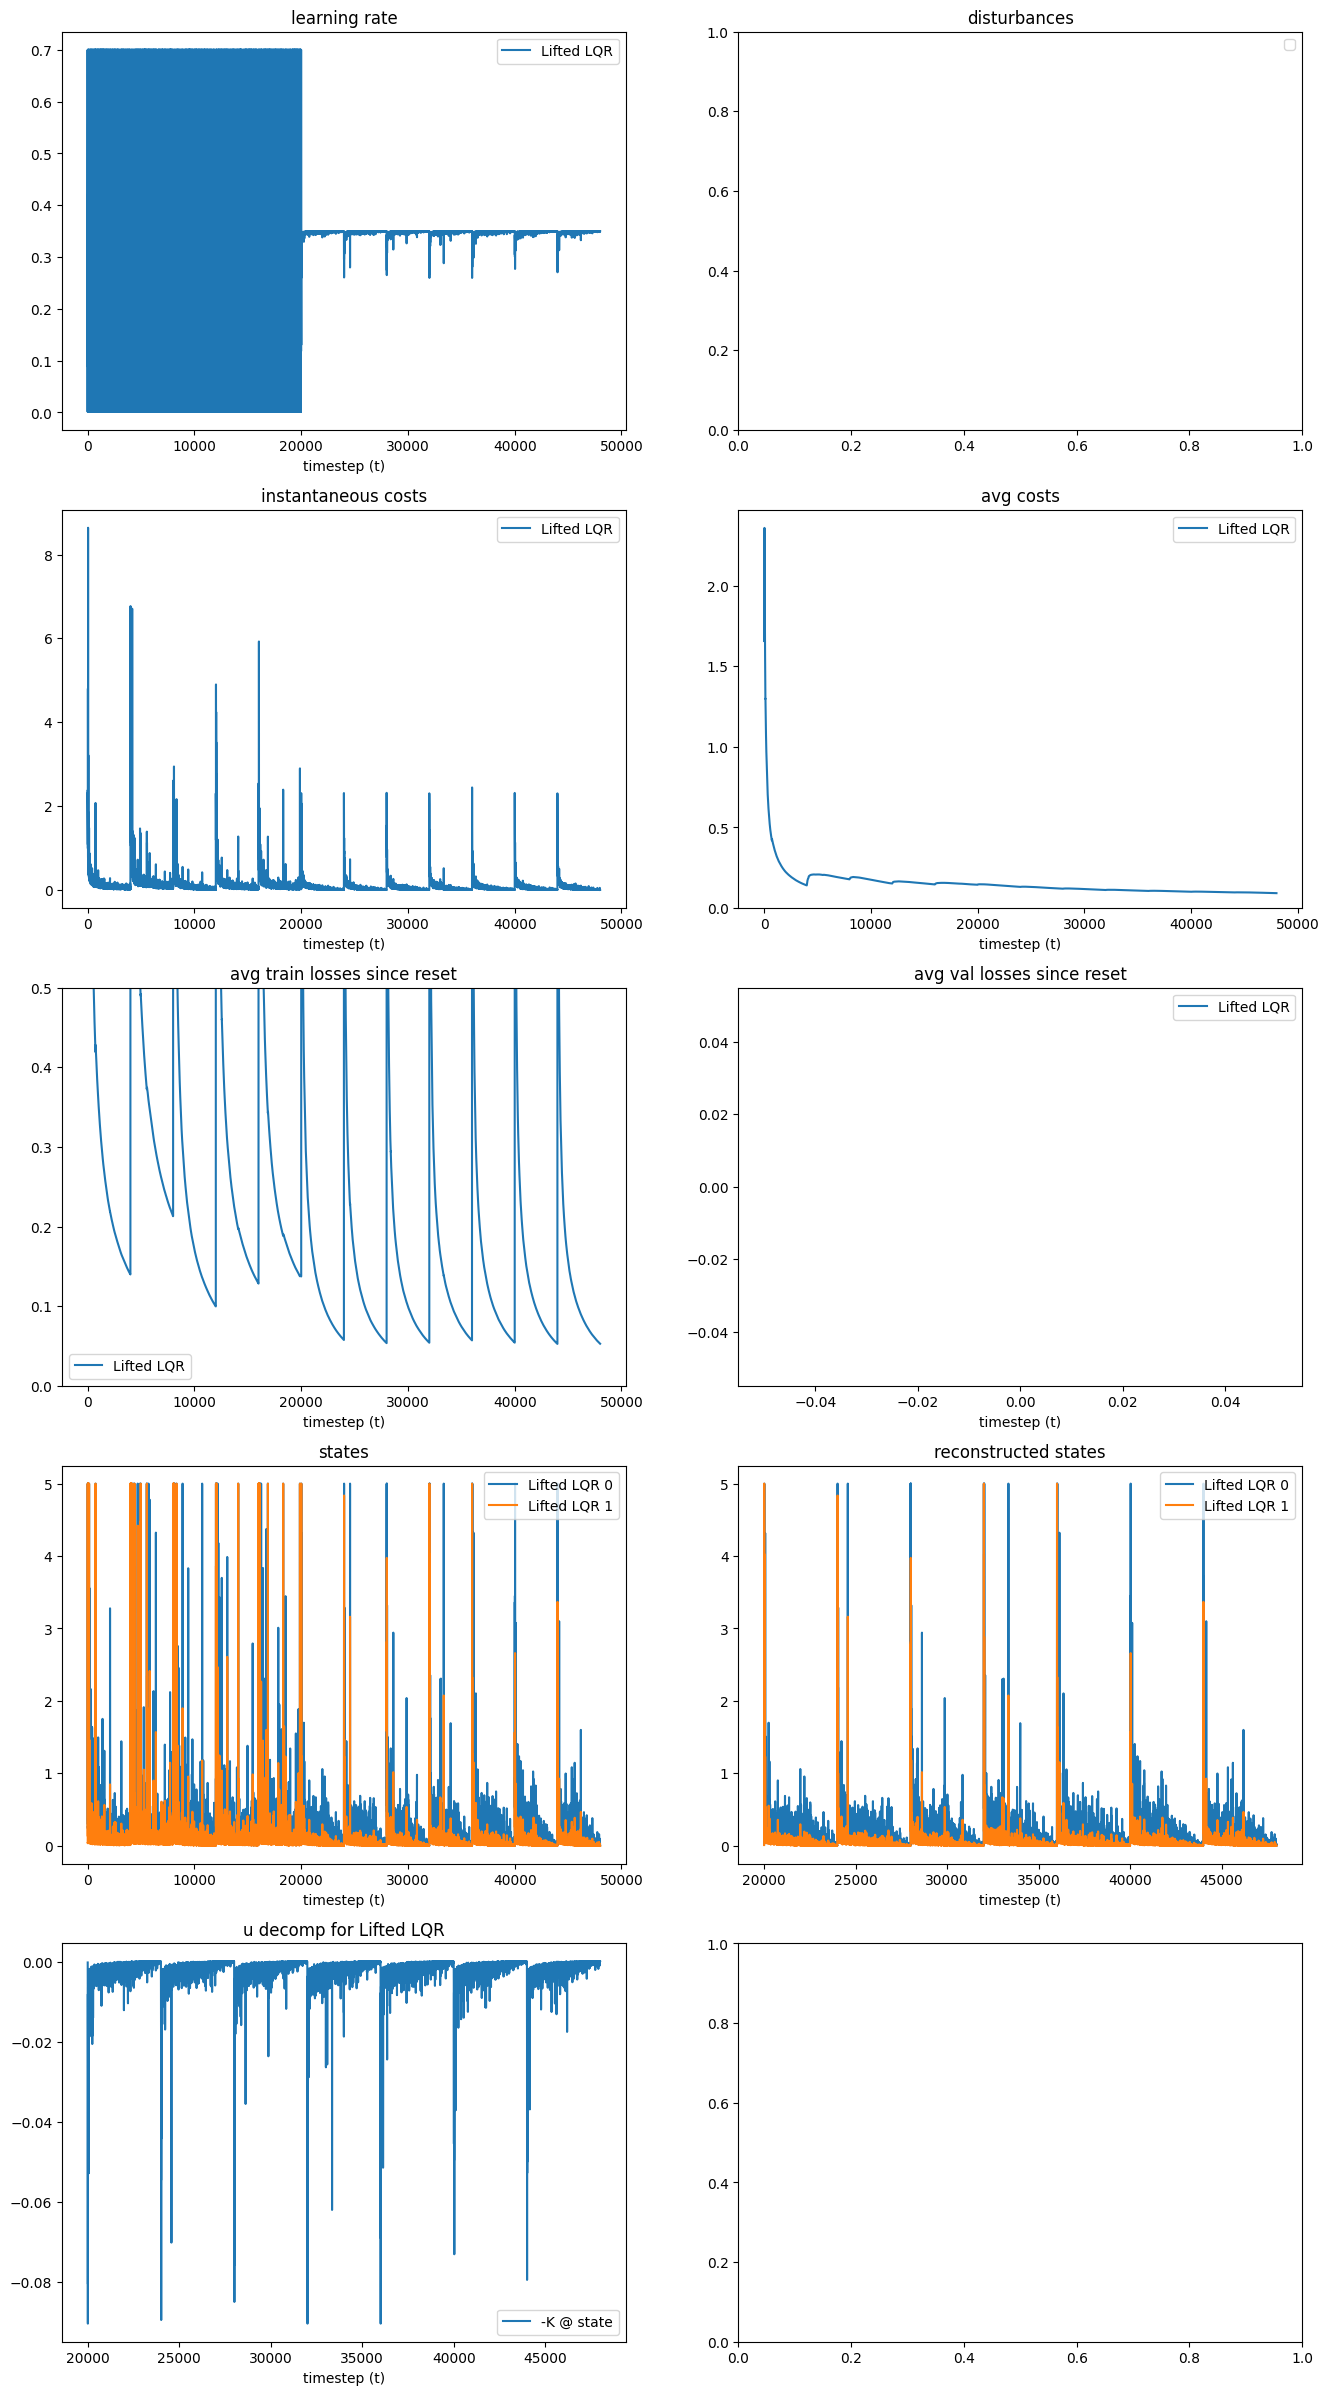

In [5]:
def plot(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'lrs', label=method)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        stats.plot(ax[2, 0], 'avg train losses since reset', label=method)
        stats.plot(ax[2, 1], 'avg val losses since reset', label=method)        
        
        for j in range(2):
            stats.plot(ax[3, 0], 'true states', label=method + ' ' + str(j), plot_idx=j)  # state
            stats.plot(ax[3, 1], 'states', label=method + ' ' + str(j), plot_idx=j)  # "state"
            stats.plot(ax[0, 1], 'disturbances', label=method + ' ' + str(j), plot_idx=j)
            
        i_ax = ax[n + i // 2, i % 2]
        idx = 0
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=idx)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=idx)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=idx)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('learning rate'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()#; ylim(_ax, 0, 0.5)
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 10000)
    _ax = ax[2, 0]; _ax.set_title('avg train losses since reset'); _ax.legend(); ylim(_ax, 0, 0.5)
    _ax = ax[2, 1]; _ax.set_title('avg val losses since reset'); _ax.legend()
    _ax = ax[3, 0]; _ax.set_title('states'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('reconstructed states'); _ax.legend()  
    pass
plot(experiment)

### Dynamic Plot

#### dynamic plot
anim = render(experiment, 'lrs', 'train losses', sliderkey='lrs', save_path=None, duration=5)
vid = anim.to_html5_video()
HTML(vid)